In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

# based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html (https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb)
# and https://colab.research.google.com/github/palver7/deeplearning/blob/master/FashionMNIST_with_ResNet18_no_resize.ipynb#scrollTo=9tBF6ykkjlri

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [ ]:
%reload_ext megaclite.client
%tag_benchmark resnet_18_fmnist
%run_remote rm ./data

In [26]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Grayscale(3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    ),
}

image_datasets = {
    x: torchvision.datasets.FashionMNIST(
        root="./data", train=x == "train", download=True, transform=data_transforms[x]
    )
    for x in ["train", "val"]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

class_names = image_datasets["train"].classes

device = torch.device("cuda:0")

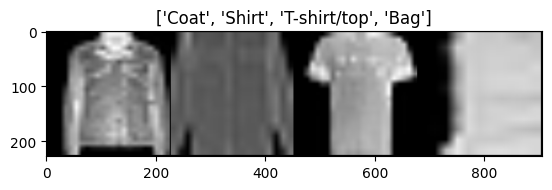

In [40]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [37]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, len(class_names))

In [39]:
%%train_remote model_ft
num_epochs = 3
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

HTML(value='')

Epoch 0/4
----------
train Loss: 0.9012 Acc: 0.6896
val Loss: 0.3165 Acc: 0.8888

Epoch 1/4
----------
train Loss: 0.6544 Acc: 0.7704
val Loss: 0.3266 Acc: 0.8863

Epoch 2/4
----------
train Loss: 0.5742 Acc: 0.7975
val Loss: 0.2849 Acc: 0.9013

Epoch 3/4
----------
train Loss: 0.5347 Acc: 0.8087
val Loss: 0.2635 Acc: 0.9060

Epoch 4/4
----------
train Loss: 0.4976 Acc: 0.8221
val Loss: 0.2770 Acc: 0.9019

Training complete in 12m 28s
Best val Acc: 0.906000
